In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS
from src.data.data_loader import load_uplift
from src.data.preprocessing import load_thickness_time_series
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import compute_love_numbers, greens_function

print(PROJECT_ROOT)

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


In [2]:
Nr = np.arange(1, 6).tolist()
radius = [6371e3, 6301e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df_alti = pd.read_csv(PROJECT_ROOT / "data" / "raw" / "kauq_altimetry.csv")
df_alti.time = pd.to_datetime(df_alti.time)
# df_mass = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "mass_time_series.csv")

df = load_uplift()
height = df.Thickness.values
uplift = df.Up_kuaq.values

df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


<AxesSubplot:>

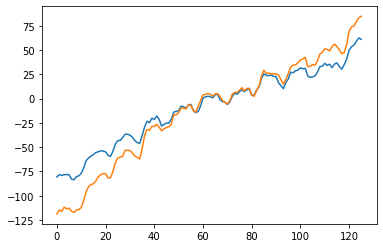

In [3]:
df.Up_mik2.plot()
df.Up_kuaq.plot()

In [161]:
# df_alti.shift(periods=2)
df_alti.index = df_alti.time
df_alti = df_alti.shift(periods=2)
df_alti

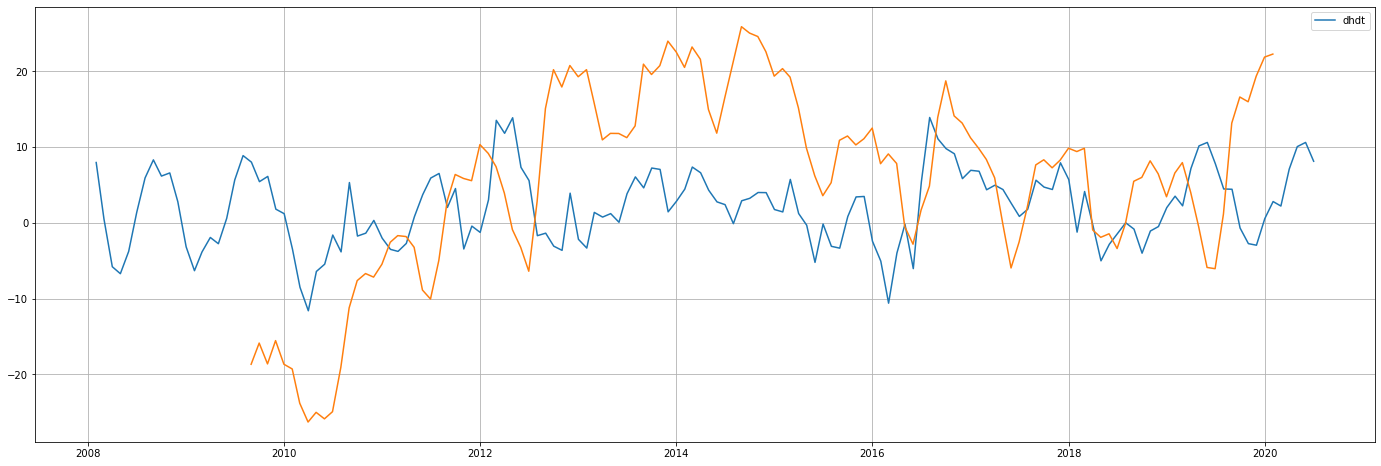

In [167]:
# df_alti.dhdt.plot()
fig, ax = plt.subplots(1, 1, figsize=(24, 8))
plt.plot(df_alti.index[-150:], -df_alti.dhdt[-150:] * 5, label="dhdt")
plt.plot(df.Time, df.Up - np.arange(len(df.Up)) * 1.3 + 100)
plt.grid()
plt.legend()

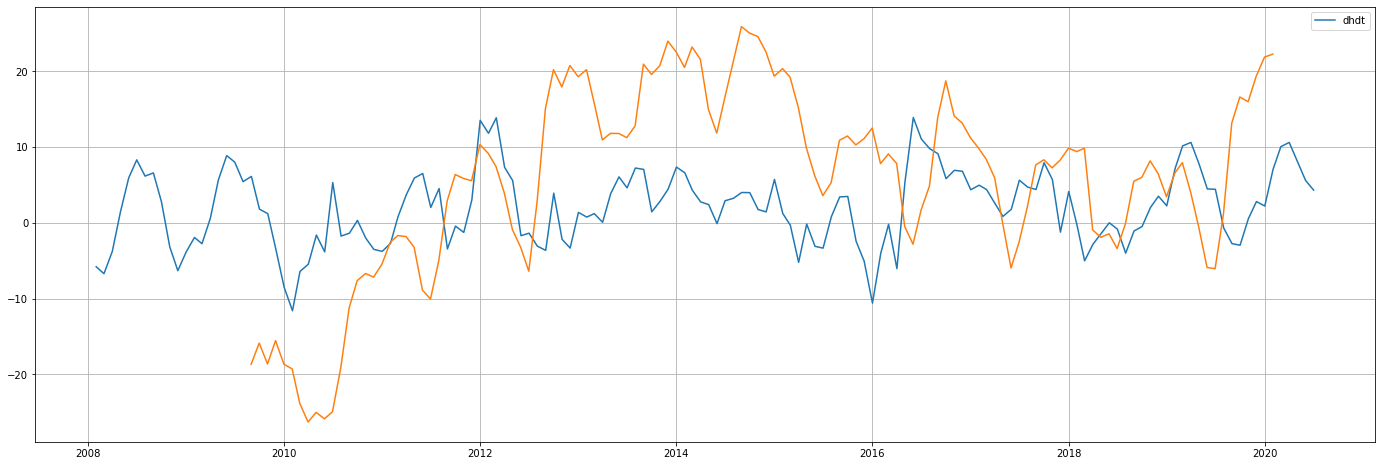

In [159]:
# df_alti.dhdt.plot()
fig, ax = plt.subplots(1, 1, figsize=(24, 8))
plt.plot(df_alti.index[-150:], -df_alti.dhdt[-150:] * 5, label="dhdt")
plt.plot(df.Time, df.Up - np.arange(len(df.Up)) * 1.3 + 100)
plt.grid()
plt.legend()

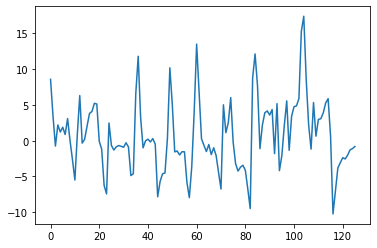

In [4]:
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(
    hlove,
    nlove,
    [68.704665, -33.214577],
    [68.58700000, -33.05270000],
    arsurf=250e3 * 250e3,
)

plt.plot(gf * height)

In [5]:
def model(height, obs=None, df_em=None):
    N = len(height)
    X = torch.arange(N)
    alpha = pyro.sample("alpha", dist.Normal(-100, 10))
    beta = pyro.sample("beta", dist.Normal(1, 1))
    sigma_w = 1  # pyro.sample("sigma", dist.HalfCauchy(0.1))

    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(
        dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 1e2
    )
    rigidity_1 = 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)

    # rigidity layer 2
    # rigidity_dist_2 = dist.Normal(1, 0.2)
    # rigidity_2 = 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)

    # dictionary = {"sample": sample1}
    df_em["rigidity"][0] = rigidity_1.item()

    # Draw Love Numbers
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)

    # Draw Greens Function
    gf = pyro.deterministic(
        "gf",
        torch.tensor(
            greens_function(
                hlove,
                nlove,
                [68.704665, -33.214577],
                [68.58700000, -33.05270000],
                arsurf=80e3 * 80e3,
            )
        ),
    )

    # Draw target
    with pyro.plate("data"):
        w = pyro.sample("w", dist.Normal(alpha + X * beta + gf * height, sigma_w), obs=obs)

    return w

In [6]:
X_train = torch.tensor(height).float()
y_train = torch.tensor(uplift).float()

In [8]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=5, warmup_steps=1, num_chains=1)
mcmc.run(X_train, y_train, df_em)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████| 6/6 [01:41, 17.00s/it, step size=1.95e-03, acc. prob=0.902]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha     -3.23      2.75     -2.00     -8.15     -1.99      5.70      1.00
        beta      0.24      0.08      0.25      0.12      0.32      4.75      0.98
  rigidity_1      0.18      0.00      0.18      0.18      0.18      5.09      1.09

Number of divergences: 0


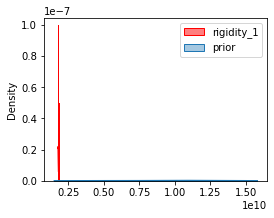

In [10]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1"]

rigidity_dist_prior = dist.Normal(torch.ones(150), 0.2)
rigidity_prior = 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4, 3))
    sns.histplot(
        samples[node] * 1e10,
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
    )
    plt.legend()
    plt.show()

In [10]:
df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,2.378261e+10,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [11]:
N = len(height)
X = torch.arange(N)

In [11]:
posterior_samples = mcmc.get_samples()

alpha_hat = mcmc.get_samples(1)["alpha"]
beta_hat = mcmc.get_samples(1)["beta"]
rigidity_hat = mcmc.get_samples(1)["rigidity_1"]

beta_hat

tensor([0.1172])

In [18]:
df_em["rigidity"][0] = rigidity_hat.item() * 1e10
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000])

In [19]:
alpha_hat

tensor([-1.2266])

In [20]:
y_hat = alpha_hat + X * beta_hat + gf * height

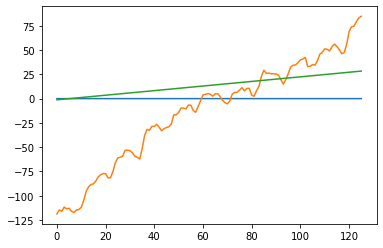

In [21]:
plt.plot(gf * height)
plt.plot(uplift)
plt.plot(y_hat)

In [14]:
from pyro.infer import Predictive
samples = mcmc.get_samples()
predictive = Predictive(model, samples)(X_train, None, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

w: (5, 126)
gf: (5, 1)


In [19]:
def prepare_counts_df(predictive):
    counts = predictive['w'].numpy()
    counts_mean = counts.mean(axis=0)
    counts_std = counts.std(axis=0)

    counts_df = pd.DataFrame({
    "feat": X_train.squeeze(),
    "mean": counts_mean,
    "high": counts_mean + counts_std,
    "low": counts_mean - counts_std,
    })

    return counts_df.sort_values(by=['feat'])

In [20]:
counts_df = prepare_counts_df(predictive)



In [27]:
counts_df['feat']

104   -2399.707520
103   -2110.419189
60    -1862.626587
84    -1673.027832
36    -1628.263306
          ...     
23     1025.606934
44     1080.955322
57     1097.791870
82     1307.483032
116    1411.306030
Name: feat, Length: 126, dtype: float32

In [25]:
# predictive['w']

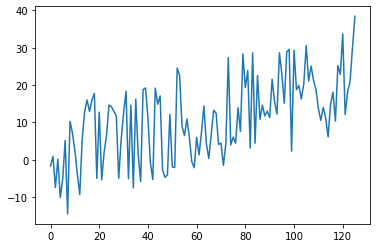

In [30]:
plt.plot(np.arange(126), counts_df['mean'])

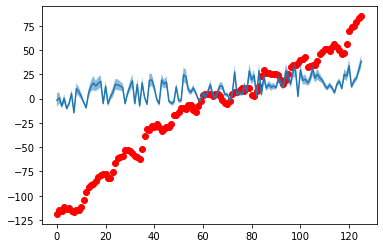

In [36]:
plt.scatter(np.arange(126),y_train, c='r')
#plt.ylabel('y')
#plt.xlabel('x')
plt.plot(np.arange(126), counts_df['mean'])
plt.fill_between(np.arange(126), counts_df['high'], counts_df['low'], alpha=0.5);

## Different things from earlier work

In [ ]:
dont run the next cells

In [ ]:
class TruncatedNormal(dist.Rejector):
    def __init__(self, loc, scale_0, max_x0):
        propose = dist.Normal(loc, scale_0)

        def log_prob_accept(x):
            return (x[0] < max_x0).type_as(x).log()

        log_scale = torch.tensor(dist.LogNormal(loc, scale_0).cdf(max_x0)).log()
        super(TruncatedLogNormal, self).__init__(propose, log_prob_accept, log_scale)

In [ ]:
## TODO: For guide support, see: https://forum.pyro.ai/t/truncated-log-normal-distribution/2002
# from torch.distributions import constraints

# class TruncatedLogNormal(dist.Rejector):
#     ...
#     @constraints.dependent_property
#     def support(self):
#         return constraints.interval(0, self.max_x0)

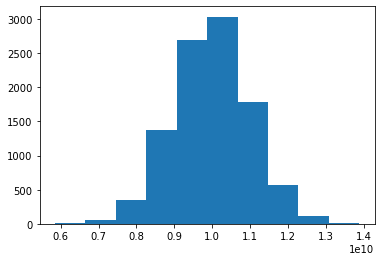

In [ ]:
diste = IntervalFoldedDistribution(
    dist.Normal(1e10 * torch.ones(10000), 1e9), lower=1e8, upper=1e12
)
plt.hist(np.array(pyro.sample("test", diste)));

tensor(0.)

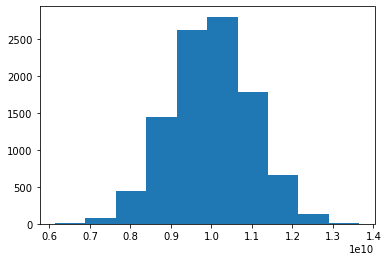

In [ ]:
samples = 1e10 * pyro.sample("test", dist.Normal(torch.ones(10000), 0.1))
plt.hist(np.array(samples))
samples[samples < 1e8].sum()

In [208]:
import numpyro
import numpyro.distributions as np_dist
from numpyro.infer import MCMC, NUTS


def model():

    # sample1 = numpyro.sample("rigidity1", bounded_rig1)
    rigidity_unscaled = numpyro.sample("rigidity_unscaled", np_dist.Normal(0, 1))

    rigidity_scaled = numpyro.deterministic(
        "rigidity_scaled", 1e10 + 1e9 * rigidity_unscaled
    )
    # rigidity_scaled = numpyro.sample("rigidity_scaled", np_dist.Uniform(1e9, 1e11))


rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 10000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_)

print(
    mcmc.get_samples()["rigidity_scaled"].min(),
    mcmc.get_samples()["rigidity_scaled"].mean(),
    mcmc.get_samples()["rigidity_scaled"].max(),
)

sample: 100%|██████████| 11000/11000 [00:14<00:00, 774.53it/s, 3 steps of size 1.26e+00. acc. prob=0.89]


-3806359800.0 -24906074.0 4083562800.0


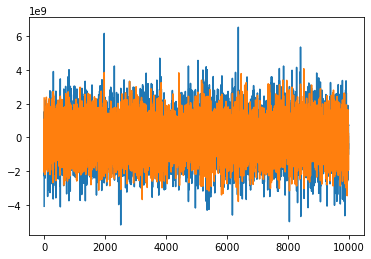

In [209]:
samples = mcmc.get_samples()["rigidity_scaled"].to_py()
plt.plot(np.diff(samples))
plt.plot(samples)

In [166]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS


def model(height, obs=None, df_em=None):
    sample1 = pyro.sample("rigidity1", dist.Normal(1, 1e-1))


# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1, num_chains=1)
mcmc.run(X_train, y_train, df_em)

print(
    mcmc.get_samples()["rigidity1"].min(),
    mcmc.get_samples()["rigidity1"].mean(),
    mcmc.get_samples()["rigidity1"].max(),
)

Sample: 100%|██████████| 1001/1001 [12:24,  1.34it/s, step size=1.16e-10, acc. prob=1.000]

tensor(0.8238) tensor(0.9997) tensor(1.)
